In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import json
import os
import joblib
from itertools import product
import warnings


# Esercizio mlflow

Problema giocattolo → Classificazione binaria (LendingClub Dataset), task del modello e’ di determinare se un individuo andrà in default su prestito in base a dati collezionati durante l'avvio della pratica.

In [7]:
data = pd.read_csv('./train_dataset.csv')
data_test = pd.read_csv('./test_dataset.csv')

In [8]:
data.head()

,loan_amount,payments_term,monthly_payment,grade,working_years,home,annual_income,verification,purpose,debt_to_income,delinquency,inquiries,open_credit_lines,derogatory_records,revolving_balance,revolving_rate,total_accounts,bankruptcies,fico_average,loan_risk
0,3000,36 months,90.48,1,10,Rent,48000.0,Source Verified,debt_consolidation,14.15,0,0,5,0,1896,39.5,12,0,777,Paid
1,12650,60 months,316.23,4,2,Rent,61500.0,Source Verified,credit_card,12.86,0,1,9,0,11200,83.0,27,0,697,Paid
2,5000,60 months,106.24,2,10,Mortgage,90000.0,Not Verified,car,11.85,0,0,16,0,31007,80.7,35,0,737,Paid
3,16000,36 months,540.88,3,3,Mortgage,35004.0,Verified,debt_consolidation,20.81,0,0,5,0,14383,92.2,23,0,722,Paid
4,17600,60 months,409.43,3,10,Mortgage,95000.0,Verified,debt_consolidation,8.07,0,3,11,0,3858,14.8,17,0,732,Charged off


In [9]:
data['loan_risk'].value_counts()

Paid           25224
Charged off     3978
Name: loan_risk, dtype: int64

In [10]:
data_train, data_val = train_test_split(data, test_size=0.2)

# Definizione di una pipeline di classificazione

All'interno della pipeline dati vengono preparati processati e dati in pasto al modello. Funzione qui sotto allena la pipeline su dati forniti come argomento usando parametri specificati nel dizionario parameters

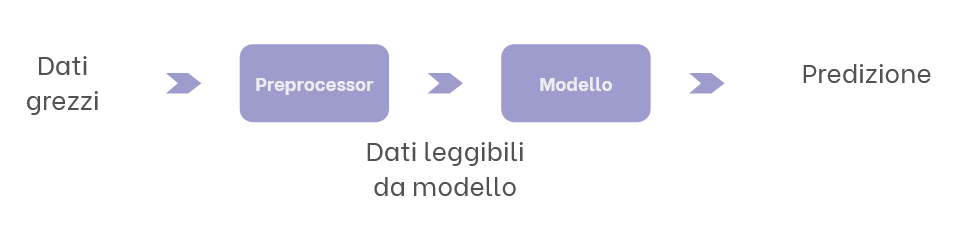

In [11]:
def train_xgboost_pipeline(data_x, data_y, parameters=None):
    # Questa funzione allena un classificatore xgboost utilizzando gli iperparametri definiti in parameters

    if parameters is None:
        parameters = dict(n_estimators=100, 
                          max_depth=4, 
                          scale_pos_weight=1,
                          learning_rate=0.1)
    
    # Preprocessamento features numeriche e categoriche

    numerical_features = data_x.select_dtypes(include="number").columns
    categorical_features = data_x.select_dtypes(include="object").columns

    
    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[('ord', numerical_transformer, numerical_features),
                                                ('cat', categorical_transformer, categorical_features)])

    # Creazione di una pipeline preprocessor + XGBoost
    
    xgb_clf = XGBClassifier(n_estimators=parameters['n_estimators'],
                           max_depth=parameters['max_depth'],
                           scale_pos_weight=parameters['scale_pos_weight'],
                           learning_rate=parameters['learning_rate'],
                           random_state=42,
                           n_jobs=4)

    xgb_pipeline = Pipeline(steps=[("preprocessing", preprocessor), 
                                   ("xgb_model", xgb_clf)])

    # Fit della pipeline

    xgb_pipeline.fit(data_x, data_y)

    return xgb_pipeline

In [12]:
clf = train_xgboost_pipeline(data_train.drop(['loan_risk'],axis=1),data_train['loan_risk'])

/home/gillus/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:40:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['loan_amount', 'monthly_payment', 'grade', 'working_years',
       'annual_income', 'debt_to_income', 'delinquency', 'inquiries',
       'open_credit_lines', 'derogatory_records', 'revolving_balance',
       'revolving_rate', 'total_accounts...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor=

Analisi metriche di classificazione modello, classification_report genera un dizionario contenente i punteggi piu\' importanti

In [14]:
from sklearn.metrics import classification_report

report_val = classification_report(data_val['loan_risk'],
                                   clf.predict(data_val.drop(['loan_risk'],axis=1)), 
                                   output_dict=True)

report_test = classification_report(data_test['loan_risk'],
                                    clf.predict(data_test.drop(['loan_risk'],axis=1)), 
                                    output_dict=True)

In [15]:
report_val

{'Charged off': {'precision': 0.7,
  'recall': 0.008244994110718492,
  'f1-score': 0.016298020954598372,
  'support': 849},
 'Paid': {'precision': 0.855599382610187,
  'recall': 0.9993990384615384,
  'f1-score': 0.9219255289660907,
  'support': 4992},
 'accuracy': 0.8553329909262113,
 'macro avg': {'precision': 0.7777996913050935,
  'recall': 0.5038220162861284,
  'f1-score': 0.46911177496034456,
  'support': 5841},
 'weighted avg': {'precision': 0.8329827286406529,
  'recall': 0.8553329909262113,
  'f1-score': 0.7902909194297516,
  'support': 5841}}

# Setup di una grid search

Andiamo a cercare la combinazione di parametri che performa meglio sul set di validazione. Facendo questo logghiamo ciascun esperimento usando mlflow


In [16]:
#! pip install mlflow

import mlflow


max_depth = [3, 6]
scale_pos_weight = [0.1, 1, 10]
learning_rate = [0.01, 0.001]
n_estimators = [100, 50]

name_experiment = 'Primissima grid-search'

parameters = product(max_depth, scale_pos_weight, learning_rate, n_estimators)
parameters_list = list(parameters)

print('Number of experiments:', len(parameters_list))

# Hyperparameter search
results = []
best_param = None
best_f1 = 0.0
warnings.filterwarnings('ignore')

for i, param in enumerate(parameters_list):
    print('Running experiment number ', i)
    with mlflow.start_run(run_name=name_experiment):
        # Tell mlflow to log the following parameters for the experiments dashboard
        mlflow.log_param('max_depth', param[0])
        mlflow.log_param('scale_pos_weight', param[1])
        mlflow.log_param('learning_rate', param[2])
        mlflow.log_param('n_estimators', param[3])
        mlflow.log_param('version', os.system('git describe --all --long'))

        try:
            parameters = dict(n_estimators=param[3], 
                              max_depth=param[0], 
                              scale_pos_weight=param[1],
                              learning_rate=param[2])

            clf = train_xgboost_pipeline(data_train.drop(['loan_risk'],axis=1),
                                         data_train['loan_risk'], 
                                         parameters=parameters)
            
            
            report_val = classification_report(data_val['loan_risk'],
                                               clf.predict(data_val.drop(['loan_risk'],axis=1)), 
                                               output_dict=True)

            report_test = classification_report(data_test['loan_risk'],
                                                clf.predict(data_test.drop(['loan_risk'],axis=1)), 
                                                output_dict=True)

            # Tell mlflow to log the following metrics
            mlflow.log_metric("recall", report_val['Charged off']['recall'])            
            mlflow.log_metric("precision", report_val['Charged off']['precision'])
            mlflow.log_metric("F1", report_val['Charged off']['f1-score'])

            # Store this artifact for each run
            json.dump(report_test, open("metrics.json", "w"))
            mlflow.log_artifact('./metrics.json')

            # save the best experiment yet (in terms of precision)
            if report_val['Charged off']['f1-score'] > best_f1:
                best_param = parameters
                best_f1 = report_val['Charged off']['f1-score']
            
                                            
            results.append([param, report_val['Charged off']['f1-score']])

        except ValueError:
            print('bad parameter combination:', param)
            continue

mlflow.end_run()
print('Best F1 was:', best_f1)
print('Using the following parameters')
print(best_param)

Number of experiments: 24
Running experiment number  0
heads/master-0-gbf553fb
[21:48:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running experiment number  1
heads/master-0-gbf553fb
[21:48:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running experiment number  2
heads/master-0-gbf553fb
[21:48:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running experiment number  3
heads/master-0-gbf553fb
[21:48

Combinazione parametri piu' performante

In [17]:
best_param

{'n_estimators': 100,
 'max_depth': 6,
 'scale_pos_weight': 0.1,
 'learning_rate': 0.01}

# Salvataggio del modello 

Salviamo il modello scelto nel nostro registro

In [18]:
from mlflow.models.signature import infer_signature

best_clf = train_xgboost_pipeline(data_train.drop(['loan_risk'], axis=1),
                                     data_train['loan_risk'], 
                                     parameters=best_param)

signature = infer_signature(data_val.drop(['loan_risk'], axis=1),
                            best_clf.predict(data_val.drop(['loan_risk'], axis=1)))


input_example = {}
for i in data_val.drop(['loan_risk'],axis=1).columns:
    input_example[i] = data_val[i].iloc[0]

    
mlflow.sklearn.save_model(best_clf, path='./model2/',signature=signature, input_example=input_example)


# per caricare uno dei modelli del registro
# saved_model_path="."
# reloaded_model = mlflow.sklearn.load_model(model_uri=saved_model_path)

[21:55:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Creazione di un'API impacchettata in un container Docker

mlflow offre la possibilita' di mettere in produzione uno dei modelli del nostro registro impacchettandolo in un container docker che espone un'API per fare queries del modello.


Per creare l'immagine docker possiamo usare la seguente linea di comando
```
mlflow models build-docker -m "./best_model" -n "xgboost_loan"     
```


Una volta che l'immagine e' stata creata possiamo fare partire il container con
```
docker run -p 5001:8080 xgboost_loan                                    
```                                        

# Query del modello

Prendiamo un esempio di input salvato e creiamo un payload per l'API

In [21]:
import requests
import json


with open('./model2/input_example.json') as f:
    sample_input = json.load(f)
sample_input['data'][0][0]=1000
print(sample_input)

{'columns': ['loan_amount', 'payments_term', 'monthly_payment', 'grade', 'working_years', 'home', 'annual_income', 'verification', 'purpose', 'debt_to_income', 'delinquency', 'inquiries', 'open_credit_lines', 'derogatory_records', 'revolving_balance', 'revolving_rate', 'total_accounts', 'bankruptcies', 'fico_average'], 'data': [[100000000000, '60 months', 214.87, 1, 8, 'Mortgage', 50000.0, 'Not Verified', 'debt_consolidation', 18.36, 0, 0, 7, 0, 9075, 44.3, 25, 0, 752]]}


In [22]:



response = requests.post(
              url='http://127.0.0.1:5001/invocations', data=json.dumps(sample_input),
              headers={"Content-type": "application/json"})
response_json = json.loads(response.text)
print('Predicted loan outcome: '+response_json[0])

Predicted loan outcome: Paid
